In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [2]:
df_cleaned = pd.read_csv("selected_sba_loans_data.csv")
df_cleaned

,ChgOffPrinGr,Term,DisbursementGross,UrbanRural,RevLineCr,LowDoc,BankState,State,NAICS,MIS_Status
0,-0.211808,-0.277691,60000.0,0,0,1,38,15,831,0
1,-0.211808,-0.595858,40000.0,0,0,1,18,15,1233,0
2,-0.211808,0.994975,287000.0,0,0,0,18,15,1157,0
3,-0.211808,-0.595858,35000.0,0,0,1,39,36,0,0
4,-0.211808,1.790392,229000.0,0,0,0,11,9,0,0
...,...,...,...,...,...,...,...,...,...,...
613718,-0.211808,-0.277691,79000.0,0,0,1,8,43,0,0
613719,-0.211808,-0.595858,85000.0,0,1,0,17,35,832,0
613720,-0.211808,0.040475,300000.0,0,0,0,5,4,436,0
613721,0.625731,-0.595858,75000.0,0,0,1,14,11,0,1


In [3]:
# Define your feature set and target, exclude DisbursementGross
X = df_cleaned[['ChgOffPrinGr', 'Term', 'UrbanRural', 'RevLineCr', 'LowDoc', 'BankState', 'State', 'NAICS']]
y = df_cleaned['MIS_Status']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Store DisbursementGross separately for later use
disbursement_test = df_cleaned.loc[X_test.index, 'DisbursementGross']  # Align DisbursementGross with X_test

In [4]:
y_train.value_counts()

MIS_Status
0    402144
1     88834
Name: count, dtype: int64

In [5]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [6]:
y_train.value_counts()

MIS_Status
1    402144
0    402144
Name: count, dtype: int64

### Function to calculate Net Profit

In [7]:
def calculate_net_profit(y_true, y_pred, disbursement_gross):
    """
    Calculate the net profit based on predictions, ground truth, and disbursement gross amounts.

    Parameters:
    - y_true: Array of true labels (0 for Default, 1 for Paid in full)
    - y_pred: Array of predicted labels (0 for Default, 1 for Paid in full)
    - disbursement_gross: Array of disbursement gross amounts corresponding to each loan

    Returns:
    - net_profit: The total net profit based on the cost-benefit matrix.
    """
    # Convert inputs to numpy arrays for easy indexing
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    disbursement_gross = np.array(disbursement_gross)

    # Calculate profits and costs for each prediction
    net_profit = 0
    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:  # True Positive: correctly granted loan
            net_profit += 0.05 * disbursement_gross[i]
        elif y_true[i] == 0 and y_pred[i] == 1:  # False Positive: incorrectly granted loan
            net_profit += -5 * (0.05 * disbursement_gross[i])

    return net_profit

# Dictionary to store Net Profit for each model
net_profits = {}

### Python Class to calculate Optimal Probability Cut-Off and Plot Gains Chart & Lift Chart

In [8]:
class LoanApplicationProfitAnalysis:
    def __init__(self, model, X_test, y_test, disbursement_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.disbursement_test = disbursement_test
        self.y_probs = None
        self.net_profit_vector = None
        self.cumulative_net_profits = None
        self.sorted_indices = None

    def predict_probabilities(self):
        """Predict probabilities for the positive class using the chosen model."""
        self.y_probs = self.model.predict_proba(self.X_test)[:, 1]

    def calculate_net_profit_vector(self):
        """Calculate the net profit for each loan application."""
        self.net_profit_vector = [
            prob * 0.05 * disbursement if true_label == 1 
            else prob * -5 * (0.05 * disbursement)
            for prob, true_label, disbursement in zip(self.y_probs, self.y_test, self.disbursement_test)
        ]

    def rank_applications_by_risk(self):
        """Rank loan applications by predicted probabilities."""
        self.sorted_indices = np.argsort(self.y_probs)[::-1]
        sorted_net_profits = np.array(self.net_profit_vector)[self.sorted_indices]
        self.cumulative_net_profits = np.cumsum(sorted_net_profits)

    def plot_gains_chart(self):
        """Plot the gains chart showing cumulative net profit."""
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.cumulative_net_profits) + 1), self.cumulative_net_profits, label="Cumulative Net Profit")
        plt.xlabel("Number of Loan Applications (Ranked by Risk)", fontsize=12)
        plt.ylabel("Cumulative Net Profit ($)", fontsize=12)
        plt.title("Gains Chart for Loan Applications", fontsize=16)
        plt.axvline(x=np.argmax(self.cumulative_net_profits), color="red", linestyle="--", label="Max Net Profit Point")
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

    def plot_lift_chart(self):
        """Plot the lift chart comparing model vs. random selection."""
        random_selection_profit = np.cumsum(np.mean(self.net_profit_vector) * np.ones(len(self.net_profit_vector)))
        plt.figure(figsize=(12, 6))
        plt.plot(range(1, len(self.cumulative_net_profits) + 1), self.cumulative_net_profits, label="Model Net Profit")
        plt.plot(range(1, len(self.cumulative_net_profits) + 1), random_selection_profit, label="Random Selection", linestyle="--")
        plt.xlabel("Number of Loan Applications (Ranked by Risk)", fontsize=12)
        plt.ylabel("Cumulative Net Profit ($)", fontsize=12)
        plt.title("Lift Chart for Loan Applications", fontsize=16)
        plt.legend()
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

    def identify_max_net_profit(self):
        """Identify the maximum net profit and corresponding cut-off probability."""
        max_net_profit_index = np.argmax(self.cumulative_net_profits)
        max_net_profit = self.cumulative_net_profits[max_net_profit_index]
        cutoff_probability = self.y_probs[self.sorted_indices[max_net_profit_index]]
#         print(f"Maximum Net Profit: ${max_net_profit:,.2f}")
#         print(f"Optimal Probability Cut-Off: {cutoff_probability:.2f}")
        return cutoff_probability

    def analyze(self):
        """Execute all steps of the analysis."""
        self.predict_probabilities()
        self.calculate_net_profit_vector()
        self.rank_applications_by_risk()
        self.plot_gains_chart()
        self.plot_lift_chart()
        return self.identify_max_net_profit()
    
# Dictionary to store Cut-Off Probabilities for each model
cutoff_prob = {}

### kNN Model

In [9]:
from sklearn.neighbors import KNeighborsClassifier

# Initialize and fit kNN
knn = KNeighborsClassifier(n_neighbors=4, metric='manhattan', p=1, weights='distance')
knn.fit(X_train, y_train)

# Predict and evaluate
y_pred_knn = knn.predict(X_test)
print("kNN Classification Report:\n", classification_report(y_test, y_pred_knn))

# Calculate net profit for kNN
net_profits['kNN'] = calculate_net_profit(y_test, y_pred_knn, disbursement_test)
print(f"\nThe Net Profit using k-Neighbors Classifier is: {net_profits['kNN']:,.2f} USD")

kNN Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95    100650
           1       0.79      0.79      0.79     22095

    accuracy                           0.92    122745
   macro avg       0.87      0.87      0.87    122745
weighted avg       0.92      0.92      0.92    122745


The Net Profit using k-Neighbors Classifier is: -49,987,428.50 USD


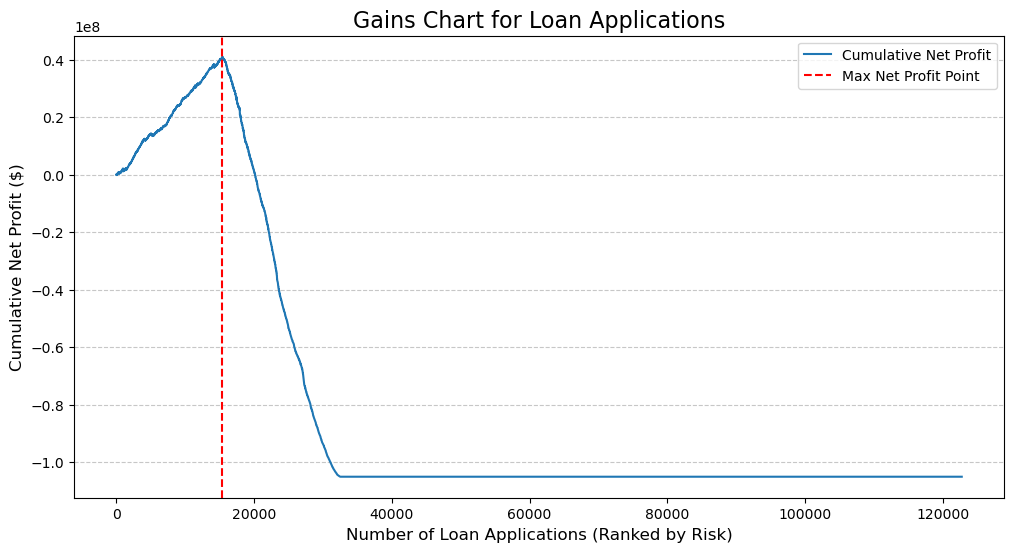

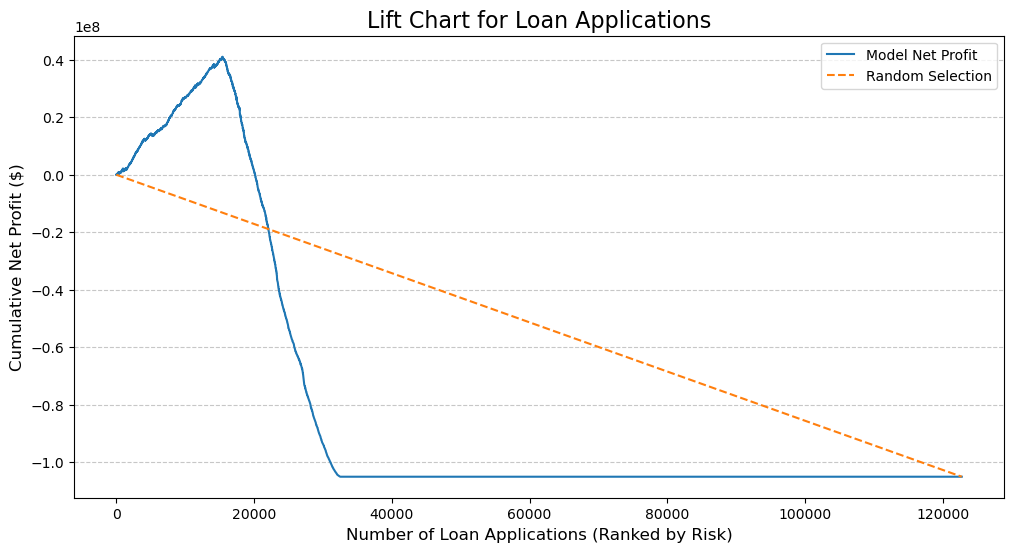

In [10]:
knn_analysis = LoanApplicationProfitAnalysis(model=knn, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['kNN'] = knn_analysis.analyze()

In [11]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['kNN']:.2f}")

Optimal Probability Cut-Off: 0.96


### Decision Tree Classifier

In [12]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and fit decision tree
tree = DecisionTreeClassifier(min_samples_split=18, min_samples_leaf=7, max_features=None, max_depth=5, criterion='gini')
tree.fit(X_train, y_train)

# Predict and evaluate
y_pred_tree = tree.predict(X_test)
print("Decision Tree Classification Report:\n", classification_report(y_test, y_pred_tree))

# Calculate net profit for Decision Tree Classifier
net_profits['DecisionTree'] = calculate_net_profit(y_test, y_pred_tree, disbursement_test)
print(f"\nThe Net Profit using Decision Tree Classifier is: {net_profits['DecisionTree']:,.2f} USD")

Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745


The Net Profit using Decision Tree Classifier is: 116,307,604.50 USD


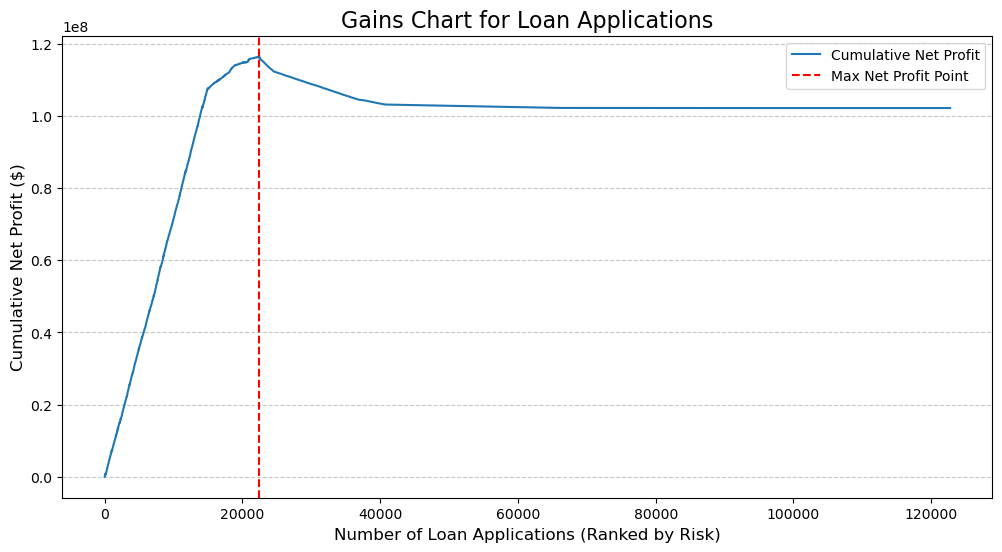

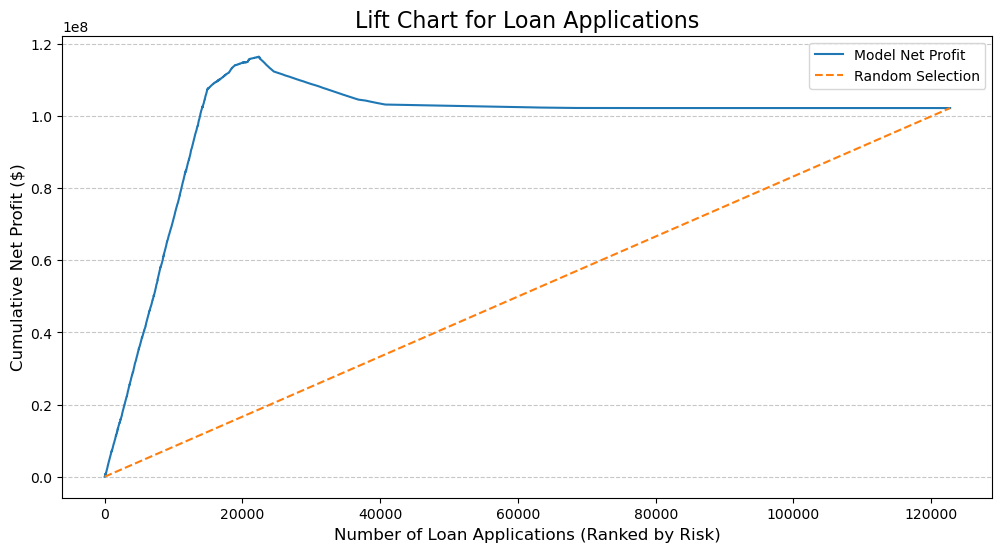

In [13]:
tree_analysis = LoanApplicationProfitAnalysis(model=tree, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['DecisionTree'] = tree_analysis.analyze()

In [14]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['DecisionTree']:.2f}")

Optimal Probability Cut-Off: 0.92


### Random Forest Classifier

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and fit random forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = random_forest.predict(X_test)
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

# Calculate net profit for Random Forest Classifier
net_profits['RandomForest'] = calculate_net_profit(y_test, y_pred_rf, disbursement_test)
print(f"\nThe Net Profit using Random Forest Classifier is: {net_profits['RandomForest']:,.2f} USD")

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.98      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745


The Net Profit using Random Forest Classifier is: 113,016,941.00 USD


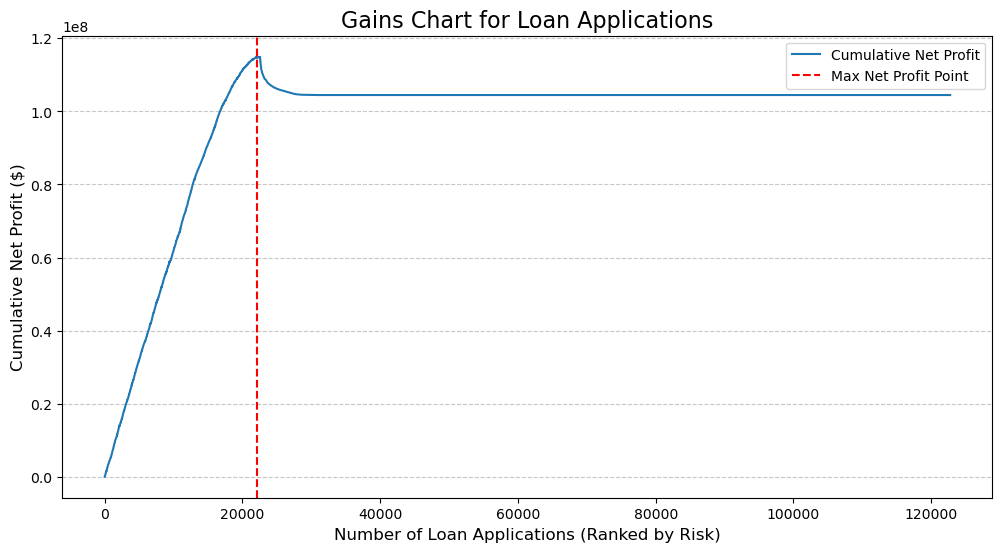

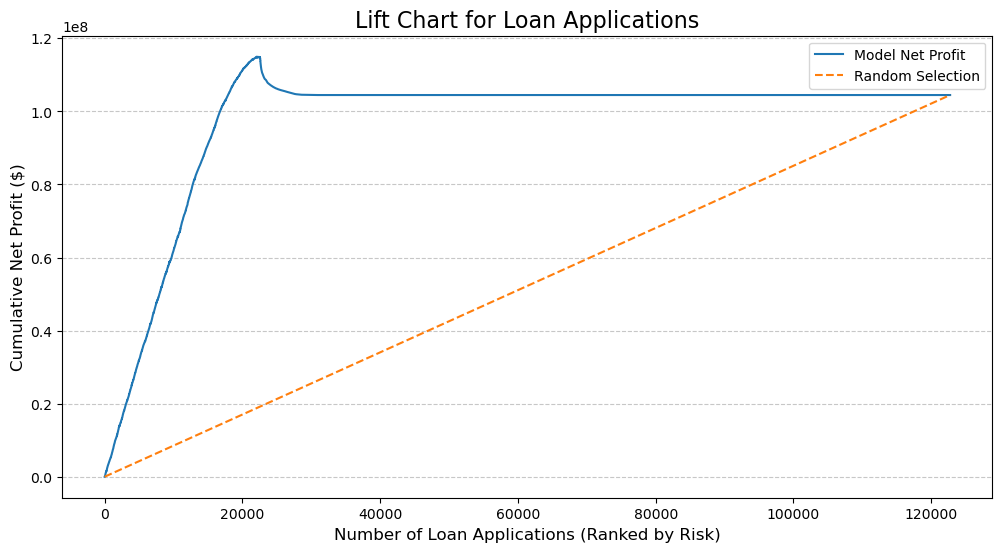

In [16]:
rf_analysis = LoanApplicationProfitAnalysis(model=random_forest, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['RandomForest'] = rf_analysis.analyze()

In [17]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['RandomForest']:.2f}")

Optimal Probability Cut-Off: 0.86


### Bagging Classifier

In [18]:
from sklearn.ensemble import BaggingClassifier

# Initialize and fit bagging classifier
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=5), random_state=42, n_estimators=10, max_samples=1.0, max_features=1.0, bootstrap_features=False, bootstrap=False)
bagging.fit(X_train, y_train)

# Predict and evaluate
y_pred_bagging = bagging.predict(X_test)
print("Bagging Classification Report:\n", classification_report(y_test, y_pred_bagging))

# Calculate net profit for Bagging Classifier
net_profits['Bagging'] = calculate_net_profit(y_test, y_pred_bagging, disbursement_test)
print(f"\nThe Net Profit using Bagging Classifier is: {net_profits['Bagging']:,.2f} USD")

Bagging Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745


The Net Profit using Bagging Classifier is: 116,307,604.50 USD


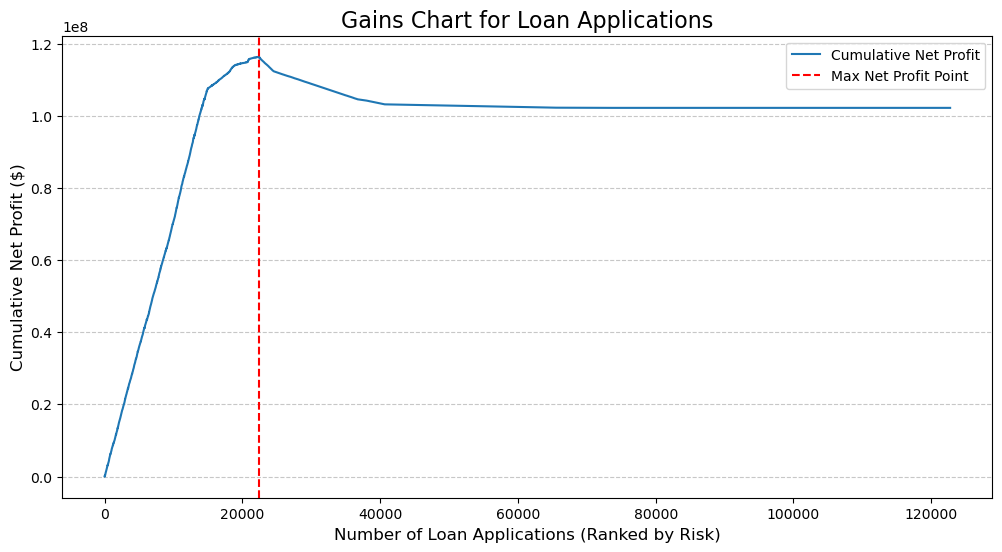

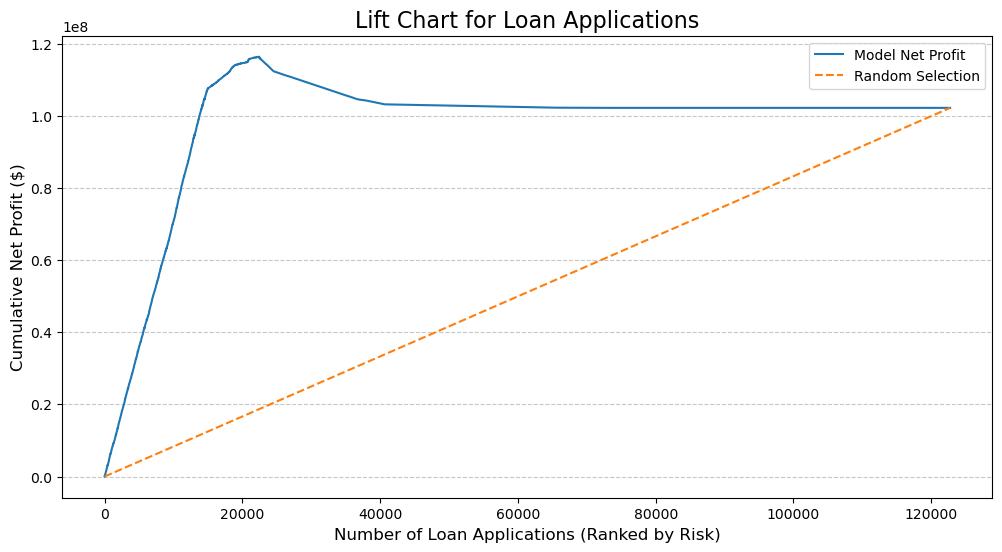

In [19]:
bagging_analysis = LoanApplicationProfitAnalysis(model=bagging, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['Bagging'] = bagging_analysis.analyze()

In [20]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['Bagging']:.2f}")

Optimal Probability Cut-Off: 0.89


### Gradient Boosting Classifier

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize and fit boosting classifier
boosting = GradientBoostingClassifier(subsample=1.0, n_estimators=100, min_samples_split=2, min_samples_leaf=2, max_features=None, max_depth=4, learning_rate=0.02, random_state=42)
boosting.fit(X_train, y_train)

# Predict and evaluate
y_pred_boosting = boosting.predict(X_test)
print("Boosting Classification Report:\n", classification_report(y_test, y_pred_boosting))

# Calculate net profit for Gradient Boosting Classifier
net_profits['Boosting'] = calculate_net_profit(y_test, y_pred_boosting, disbursement_test)
print(f"\nThe Net Profit using Gradient Boosting Classifier is: {net_profits['Boosting']:,.2f} USD")

Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745


The Net Profit using Gradient Boosting Classifier is: 116,307,604.50 USD


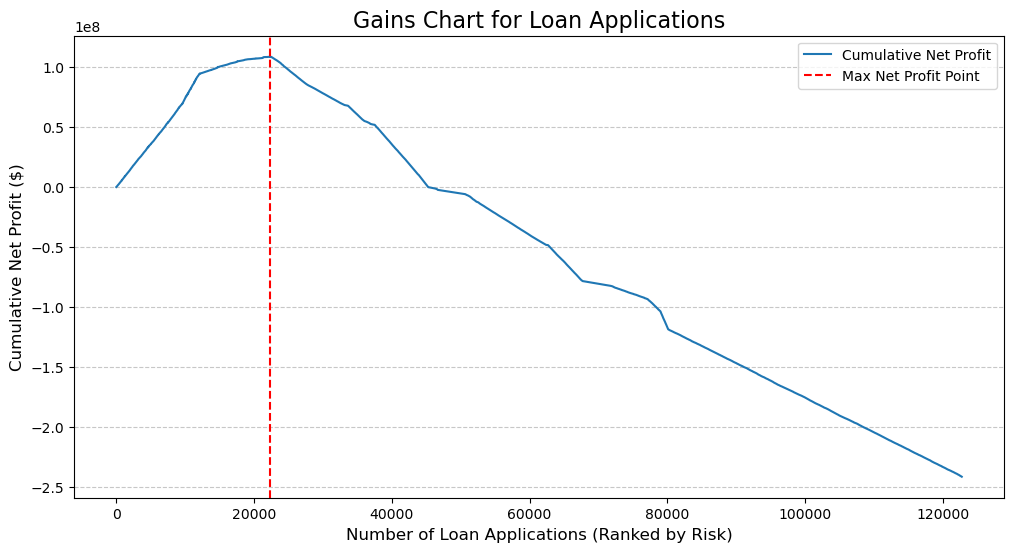

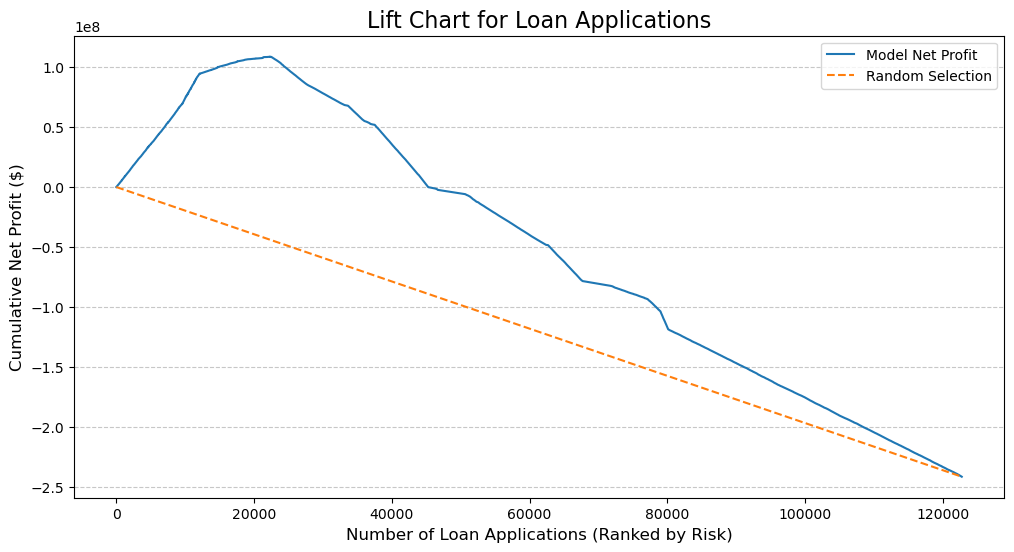

In [22]:
boosting_analysis = LoanApplicationProfitAnalysis(model=boosting, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['Boosting'] = boosting_analysis.analyze()

In [23]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['Boosting']:.2f}")

Optimal Probability Cut-Off: 0.88


### eXtream Gradient Boosting Classifier (XGBoost)

In [24]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

# Initialize XGBoost Classifier with parameters
xgb_model = xgb.XGBClassifier(
    n_estimators=100,        # Number of trees
    max_depth=4,             # Maximum tree depth
    learning_rate=0.02,      # Learning rate (similar to Gradient Boosting)
    min_child_weight=2,      # Equivalent to min_samples_leaf
    subsample=1.0,           # Use all samples
    colsample_bytree=1.0,    # Use all features
    objective='binary:logistic',  # Objective for binary classification
    random_state=42          # For reproducibility
)

# Perform cross-validation to evaluate performance
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgboost = xgb_model.predict(X_test)
print("Extream Boosting Classification Report:\n", classification_report(y_test, y_pred_xgboost))

# Calculate net profit for Gradient Boosting Classifier
net_profits['XGBoosting'] = calculate_net_profit(y_test, y_pred_xgboost, disbursement_test)
print(f"\nThe Net Profit using Extreme Gradient Boosting Classifier is: {net_profits['XGBoosting']:,.2f} USD")

Extream Boosting Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745


The Net Profit using Extreme Gradient Boosting Classifier is: 116,372,293.10 USD


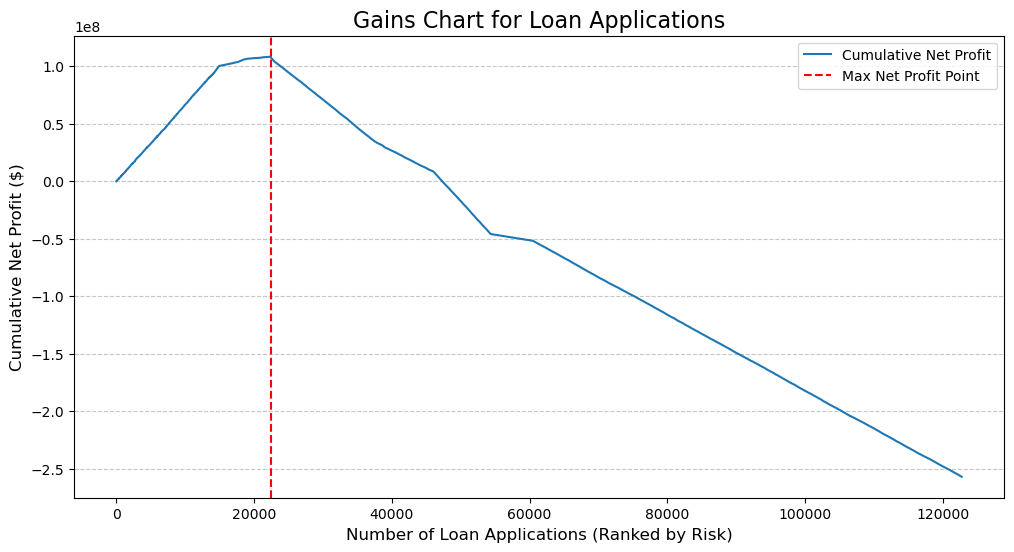

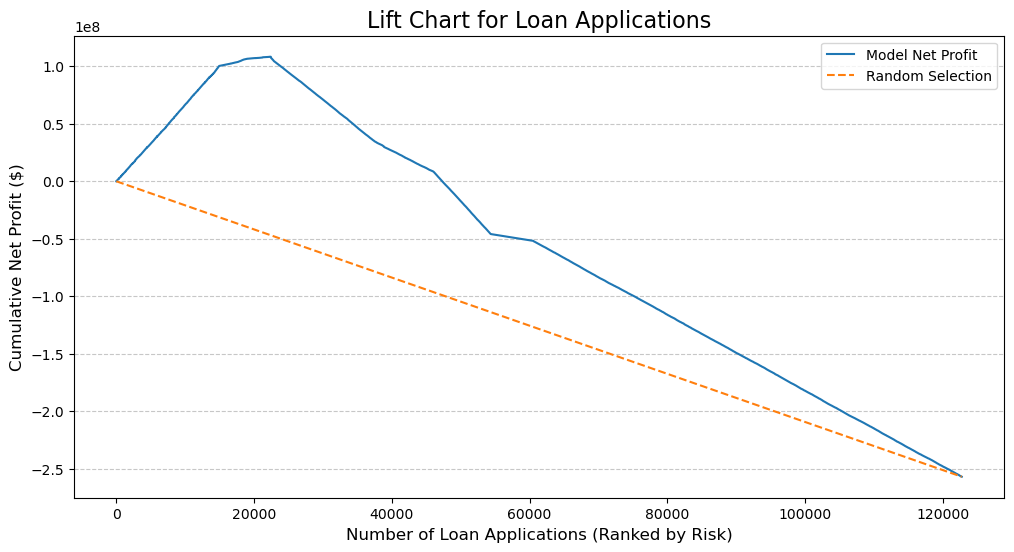

In [25]:
xgb_analysis = LoanApplicationProfitAnalysis(model=xgb_model, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['XGBoosting'] = xgb_analysis.analyze()

In [26]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['XGBoosting']:.2f}")

Optimal Probability Cut-Off: 0.87


### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegressionCV

# Initialize and fit logistic regression
logit = LogisticRegressionCV(random_state=42, max_iter=1000, penalty='l2', solver='lbfgs', cv=5)
logit.fit(X_train, y_train)

# Predict and evaluate
y_pred_logit = logit.predict(X_test)
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_logit))

# Calculate net profit for Gradient Boosting Classifier
net_profits['Logistic'] = calculate_net_profit(y_test, y_pred_logit, disbursement_test)
print(f"\nThe Net Profit using Logistic Regression is: {net_profits['Logistic']:,.2f} USD")

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    100650
           1       0.98      0.95      0.97     22095

    accuracy                           0.99    122745
   macro avg       0.98      0.97      0.98    122745
weighted avg       0.99      0.99      0.99    122745


The Net Profit using Logistic Regression is: 115,629,050.45 USD


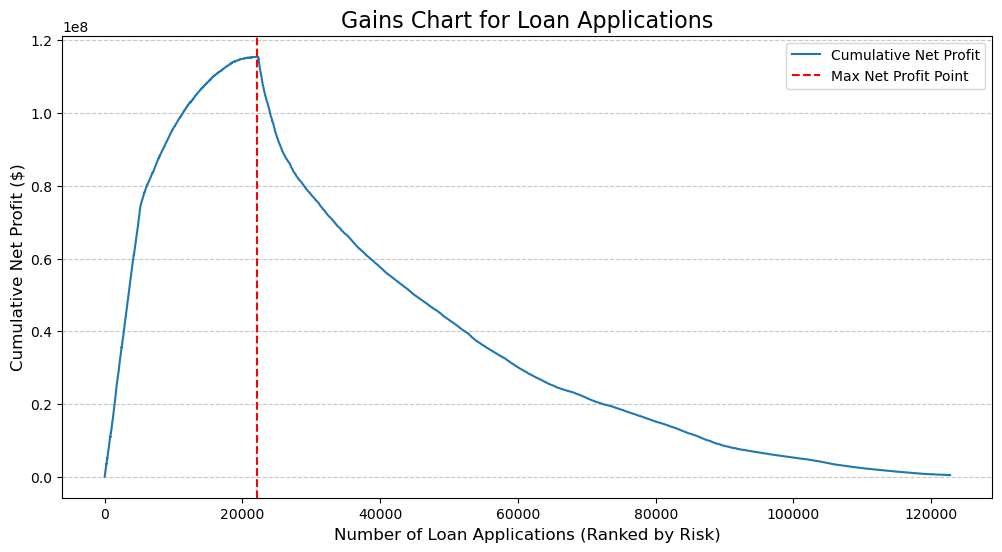

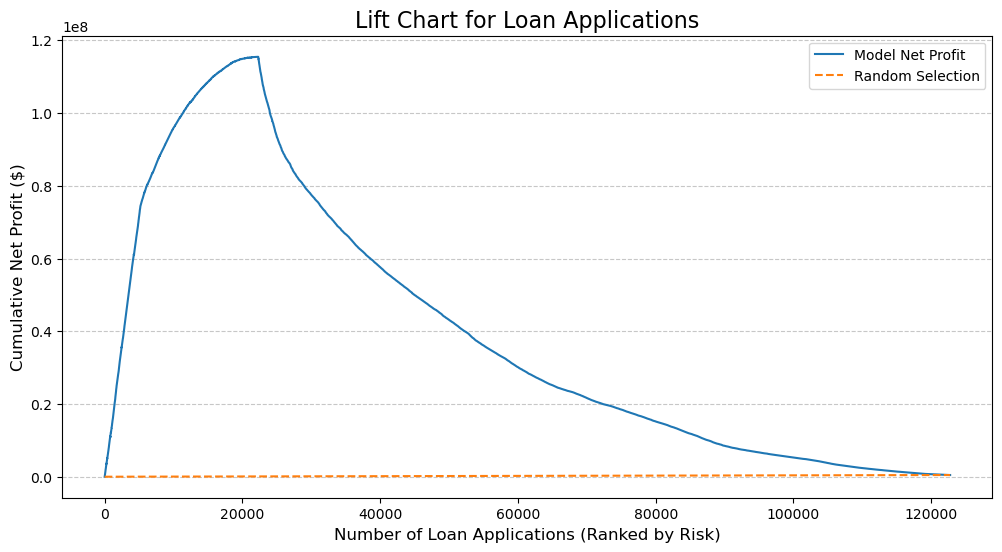

In [28]:
logit_analysis = LoanApplicationProfitAnalysis(model=logit, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['Logistic'] = logit_analysis.analyze()

In [29]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['Logistic']:.2f}")

Optimal Probability Cut-Off: 0.33


### Neural Network

In [30]:
from sklearn.neural_network import MLPClassifier

# Initialize and fit Neural Network
nn = MLPClassifier(hidden_layer_sizes=(50, 25), solver='adam', activation='relu', max_iter=1000, random_state=42)
nn.fit(X_train, y_train)

# Predict and evaluate
y_pred_nn = nn.predict(X_test)
print("Neural Network Classification Report:\n", classification_report(y_test, y_pred_nn))

# Calculate net profit for Neural Network
net_profits['NeuralNetwork'] = calculate_net_profit(y_test, y_pred_nn, disbursement_test)
print(f"\nThe Net Profit using Neural Network is: {net_profits['NeuralNetwork']:,.2f} USD")

Neural Network Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    100650
           1       0.97      0.99      0.98     22095

    accuracy                           0.99    122745
   macro avg       0.99      0.99      0.99    122745
weighted avg       0.99      0.99      0.99    122745


The Net Profit using Neural Network is: 116,324,745.10 USD


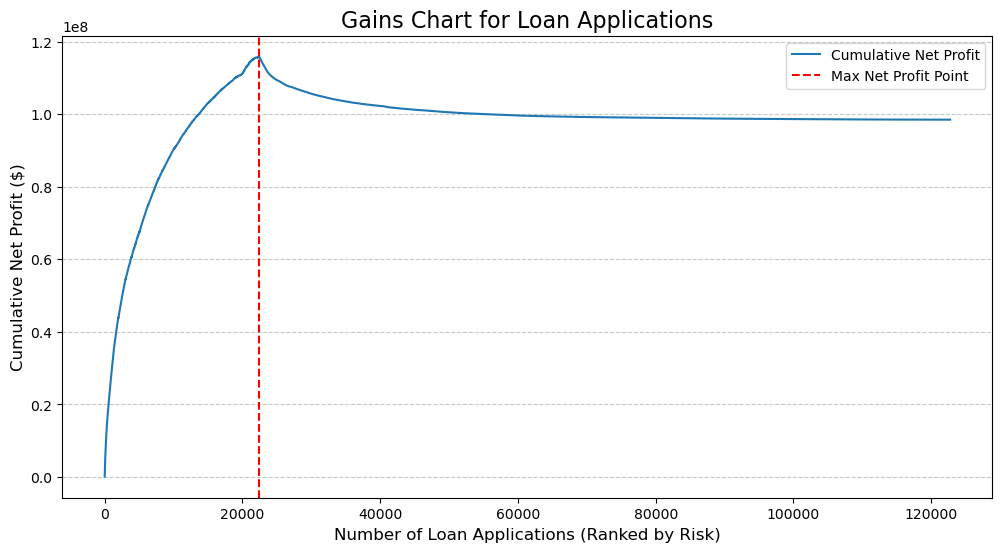

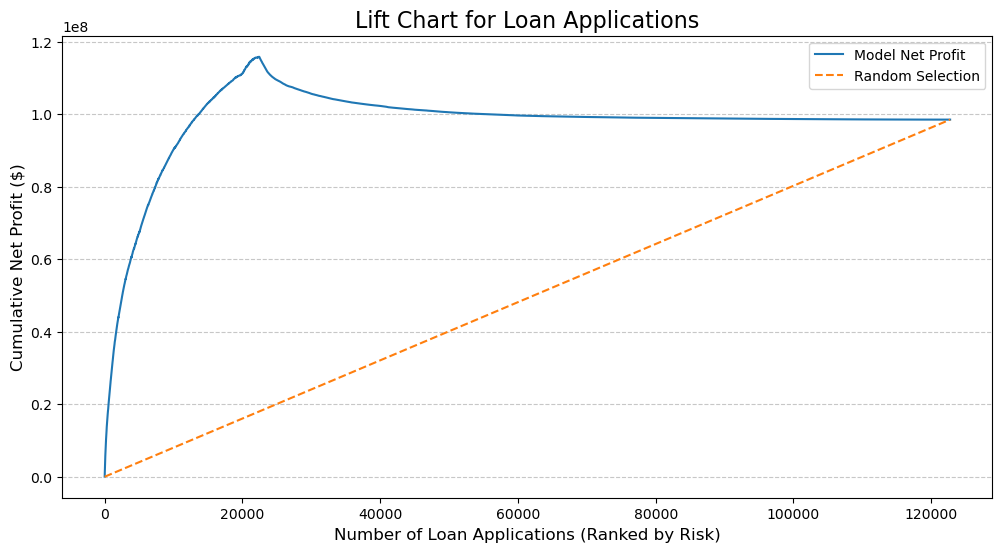

In [31]:
nn_analysis = LoanApplicationProfitAnalysis(model=nn, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['NeuralNetwork'] = nn_analysis.analyze()

In [32]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['NeuralNetwork']:.2f}")

Optimal Probability Cut-Off: 0.20


### Discriminant Analysis

In [33]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 

# Linear Discriminant Analysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_test)
print("Linear Discriminant Analysis Classification Report:\n", classification_report(y_test, y_pred_lda))

# Calculate net profit for Linear Discriminant Analysis
net_profits['LinearDiscriminant'] = calculate_net_profit(y_test, y_pred_lda, disbursement_test)
print(f"\nThe Net Profit using Linear Discriminant Analysis is: {net_profits['LinearDiscriminant']:,.2f} USD")

Linear Discriminant Analysis Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.77      0.86    100650
           1       0.46      0.90      0.61     22095

    accuracy                           0.80    122745
   macro avg       0.72      0.84      0.74    122745
weighted avg       0.88      0.80      0.82    122745


The Net Profit using Linear Discriminant Analysis is: -729,096,566.95 USD


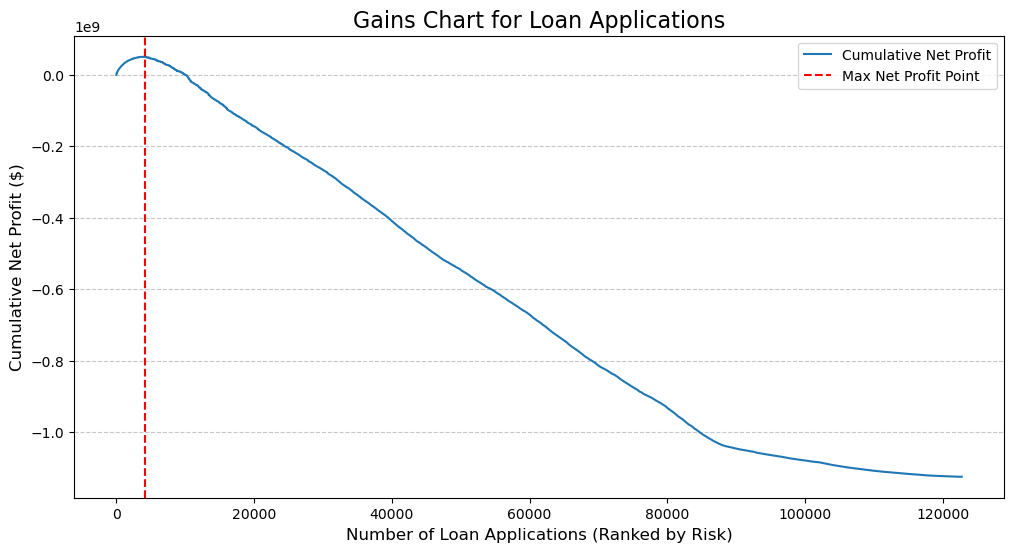

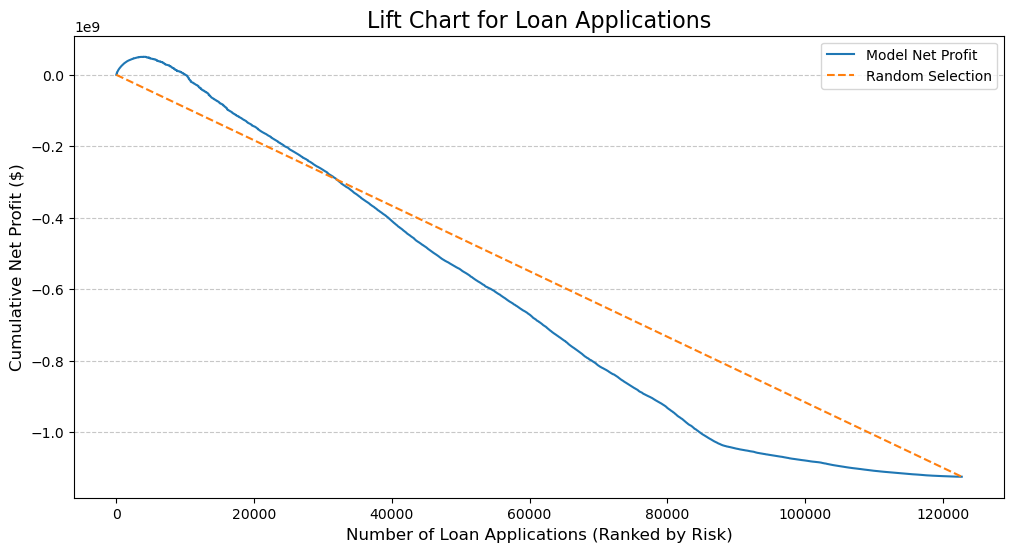

In [34]:
lda_analysis = LoanApplicationProfitAnalysis(model=lda, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['LinearDiscriminant'] = lda_analysis.analyze()

In [35]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['LinearDiscriminant']:.2f}")

Optimal Probability Cut-Off: 0.87


In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# Quadratic Discriminant Analysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_test)
print("Quadratic Discriminant Analysis Classification Report:\n", classification_report(y_test, y_pred_qda))

# Calculate net profit for Quadratic Discriminant Analysis
net_profits['QuadraticDiscriminant'] = calculate_net_profit(y_test, y_pred_qda, disbursement_test)
print(f"\nThe Net Profit using Quadratic Discriminant Analysis is: {net_profits['QuadraticDiscriminant']:,.2f} USD")

Quadratic Discriminant Analysis Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98    100650
           1       0.91      0.92      0.91     22095

    accuracy                           0.97    122745
   macro avg       0.94      0.95      0.95    122745
weighted avg       0.97      0.97      0.97    122745


The Net Profit using Quadratic Discriminant Analysis is: 65,232,514.65 USD


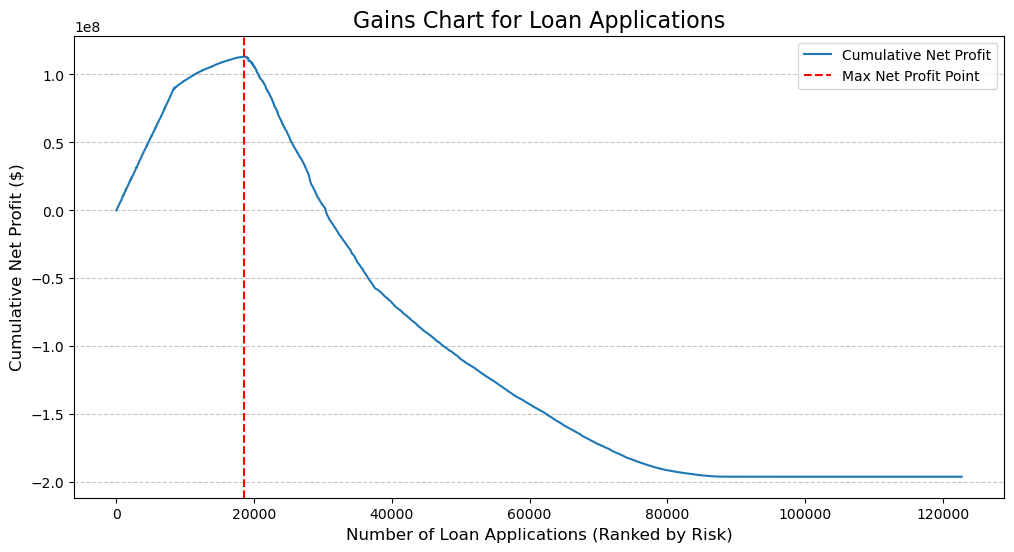

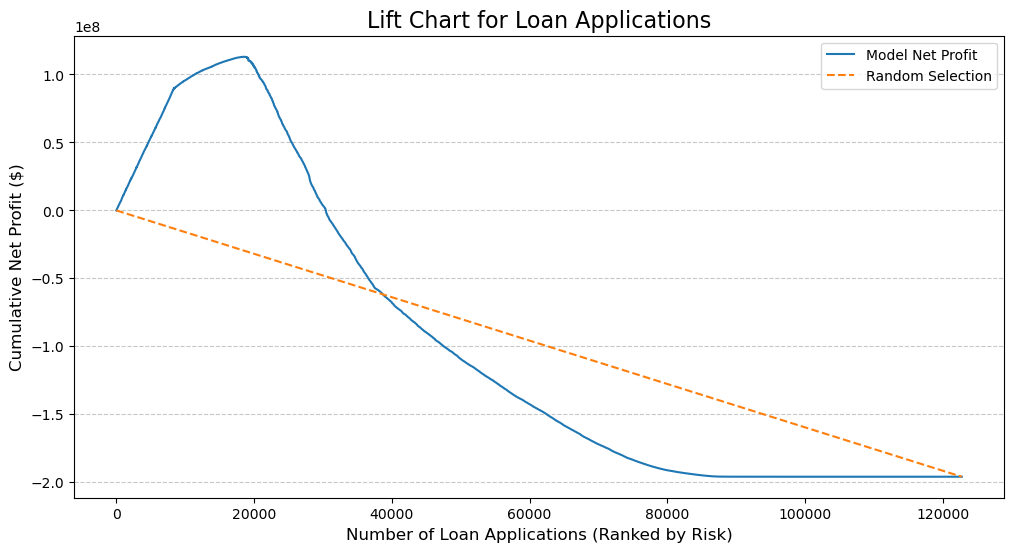

In [37]:
qda_analysis = LoanApplicationProfitAnalysis(model=qda, X_test=X_test, y_test=y_test, disbursement_test=disbursement_test)
cutoff_prob['QuadraticDiscriminant'] = qda_analysis.analyze()

In [38]:
print(f"Optimal Probability Cut-Off: {cutoff_prob['QuadraticDiscriminant']:.2f}")

Optimal Probability Cut-Off: 0.84


### Visualizing the Net Profits of each model

In [39]:
# Display net profits
print("Net Profits for All Models:")
for model_name, profit in net_profits.items():
    print(f"{model_name}: ${profit:,.2f}")

Net Profits for All Models:
kNN: $-49,987,428.50
DecisionTree: $116,307,604.50
RandomForest: $113,016,941.00
Bagging: $116,307,604.50
Boosting: $116,307,604.50
XGBoosting: $116,372,293.10
Logistic: $115,629,050.45
NeuralNetwork: $116,324,745.10
LinearDiscriminant: $-729,096,566.95
QuadraticDiscriminant: $65,232,514.65


In [40]:
# Separate profits and losses
profits = {key: value for key, value in net_profits.items() if value > 0}
losses = {key: value for key, value in net_profits.items() if value < 0}

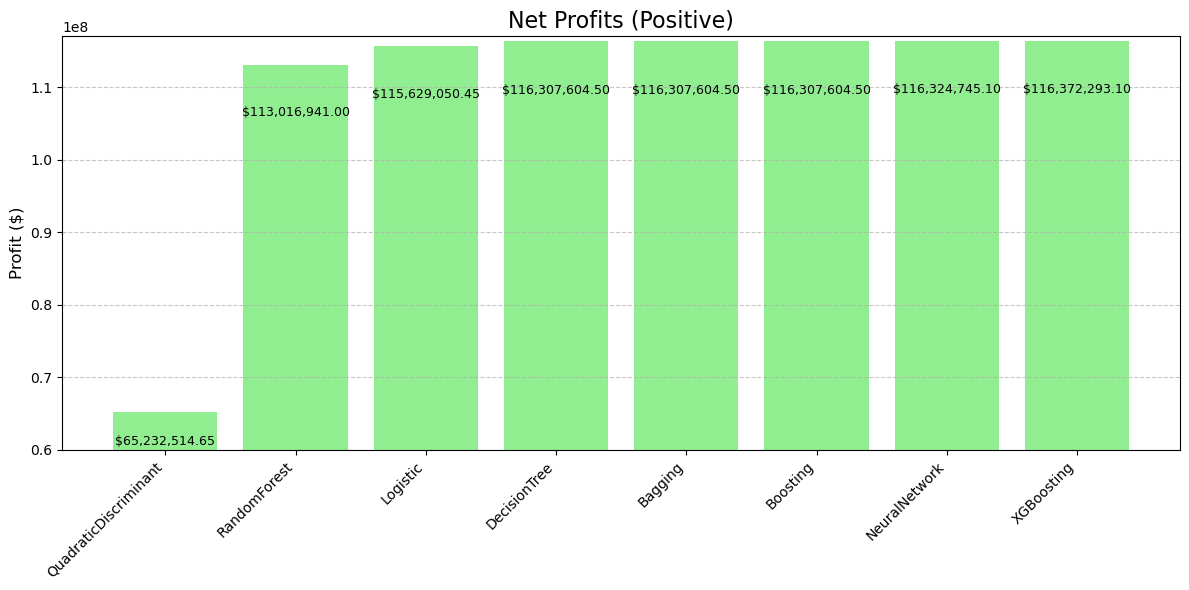

In [41]:
# Sort net profits in ascending order
sorted_net_profits = dict(sorted(profits.items(), key=lambda item: item[1]))

# Graph 1: Bar chart for profits with values inside bars
plt.figure(figsize=(12, 6))
bars = plt.bar(sorted_net_profits.keys(), sorted_net_profits.values(), color='lightgreen')

# Add values inside bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.05), f"${yval:,.2f}",
             ha='center', va='top', fontsize=9, color='black')

# Set y-axis limits
plt.ylim(60000000, 117000000)

# Chart formatting
plt.title('Net Profits (Positive)', fontsize=16)
plt.ylabel('Profit ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

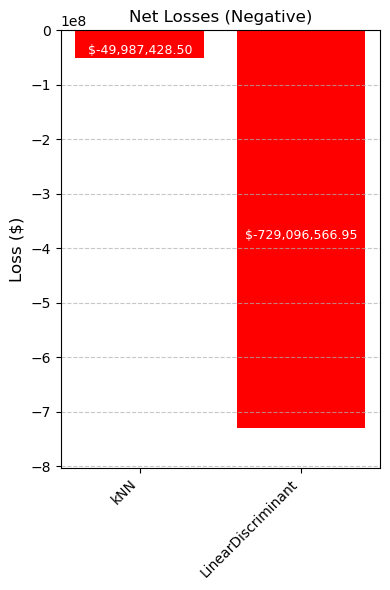

In [42]:
# Graph 2: Bar chart for losses with values inside bars
plt.figure(figsize=(4, 6))
bars = plt.bar(losses.keys(), losses.values(), color='red')

# Add values inside bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval - (yval * 0.5), f"${yval:,.2f}",
             ha='center', va='top', fontsize=9, color='white')

# Set y-axis to ensure the focus is on the loss range
plt.ylim(min(losses.values()) * 1.1, 0)

# Chart formatting
plt.title('Net Losses (Negative)', fontsize=12)
plt.ylabel('Loss ($)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Visualizing the Cut-off Probabilities of each model

In [43]:
# Display cut-off probabilities of all models
print("Cut-off Probabilities for All Models:")
for model_name, probability in cutoff_prob.items():
    print(f"{model_name}: {probability:,.2f}")

Cut-off Probabilities for All Models:
kNN: 0.96
DecisionTree: 0.92
RandomForest: 0.86
Bagging: 0.89
Boosting: 0.88
XGBoosting: 0.87
Logistic: 0.33
NeuralNetwork: 0.20
LinearDiscriminant: 0.87
QuadraticDiscriminant: 0.84


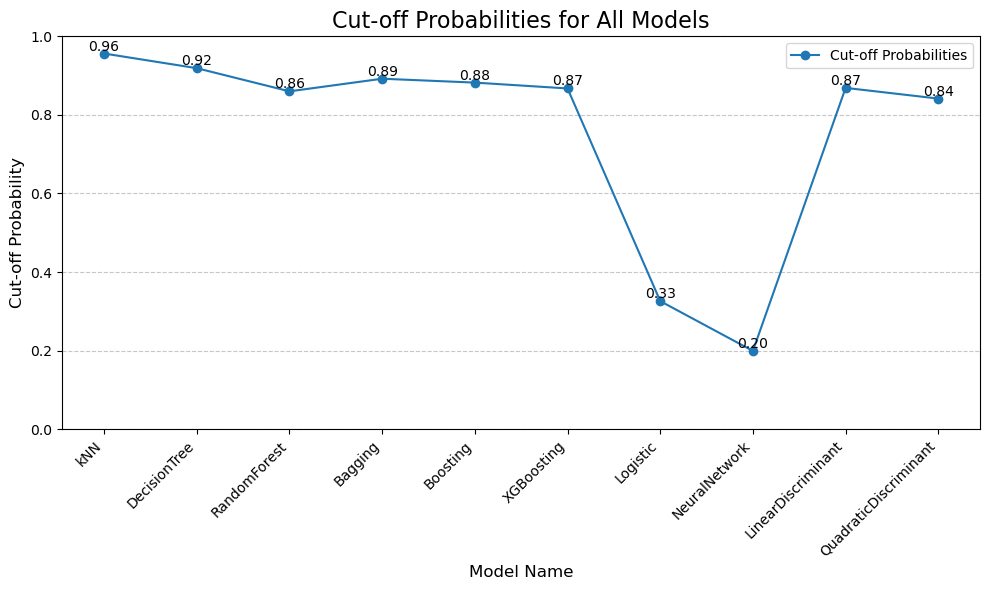

In [44]:
# Plotting the line chart
plt.figure(figsize=(10, 6))
x_values = list(cutoff_prob.keys())
y_values = list(cutoff_prob.values())

plt.plot(x_values, y_values, marker='o', linestyle='-', label="Cut-off Probabilities")
plt.title("Cut-off Probabilities for All Models", fontsize=16)
plt.xlabel("Model Name", fontsize=12)
plt.ylabel("Cut-off Probability", fontsize=12)
plt.ylim(0, 1)  # Ensuring the y-axis represents probabilities

# Adding values at each point
for x, y in zip(x_values, y_values):
    plt.text(x, y, f"{y:.2f}", fontsize=10, ha='center', va='bottom')  # Display values above points

plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()